In [1]:
import torch
import pandas as pd
from transformers import Trainer, TrainingArguments
from torch.optim import AdamW
from transformers import get_scheduler
import torch.nn as nn
from src.load_dataloader import initial_dataloader
from src.load_dataloader import initial_dataloader_reconstruct
from src.evaluation import evaluate
from src.evaluation import evaluate_process
from src.load_config import load_config
from src.evaluation import show_sentence
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

max_length = 64

In [2]:
print(torch.__version__)

2.1.1+cu118


In [3]:
model, tokenizer, device = load_config(max_length)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# import data
df = pd.read_csv('data_preprocess/datasets_combine.csv')
train_df, val_df,test_df, train_dataset,val_dataset, test_dataset,train_loader, val_loader, test_loader = initial_dataloader(df, tokenizer, max_length)

In [5]:
def train_baseline():
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_epochs = 100
    num_training_steps = num_epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        accuracy = evaluate(model, val_loader, device)
        print(f"Epoch {epoch+1}: Accuracy = {accuracy:.2f}")
        
    # save 
    torch.save(model, 'baseline_model.pth')
    
# train_baseline()

In [ ]:
# using hugging face way to train
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    num_train_epochs=3,              # Total number of training epochs
    per_device_train_batch_size=8,   # Batch size per device during training
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

trainer.train()

In [6]:
def triain_reconstruct():
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_epochs = 100
    num_training_steps = num_epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        accuracy = evaluate(model, val_loader, device)
        print(f"Epoch {epoch+1}: Accuracy = {accuracy:.2f}")
        
    # save 
    torch.save(model, 'baseline_model_reconstruct.pth')
    
# triain_reconstruct()

In [7]:
# baseline_model = torch.load('baseline_model_reconstruct.pth')
# baseline_model.to(device)

In [8]:
# show sentence
for i in range(10):
    show_sentence(i, test_df, tokenizer, model, device, max_length)

Original Sentence: SICINIUS:One thus descended,That hath beside well in his person wroughtTo be set high in place, we did commendTo your remembrances: but you have found,Scaling his present bearing with his past,That he's your fixed enemy, and revokeYour sudden approbation
Target Sentence style: PM predicts the next election will be re-run of '92 when Major beat Kinnock
Generated Sentence: SICINIUS:One thus descended,That hath beside well in his person wroughtTo be set high in place, and revokeYour sudden approbation to the written style of PM predicts the next election will be re-run of '92 when Major beat Kinn
Original Sentence: O cursed wretch,That knew'st this was the prince,and wouldst adventureTo mingle faith with him! Undone! undone!If I might die within this hour, I have livedTo die when I desire
Target Sentence style: But with Vincent Kompany out injured, now is the time for Mangala to shine
Generated Sentence: is the time for Mangala to shine in the written style of O cursed 

In [9]:
predictions, labels = evaluate_process(test_df, model,tokenizer, device, max_length)

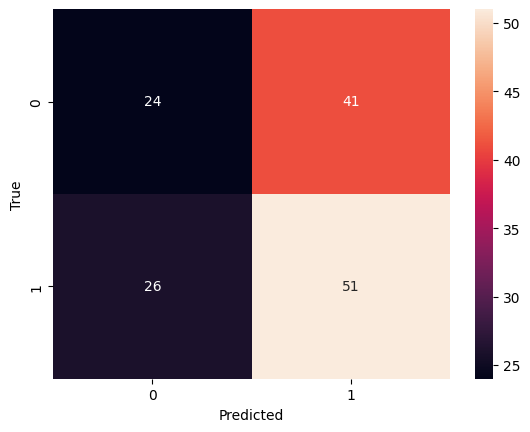

In [11]:
cm = confusion_matrix(labels, predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

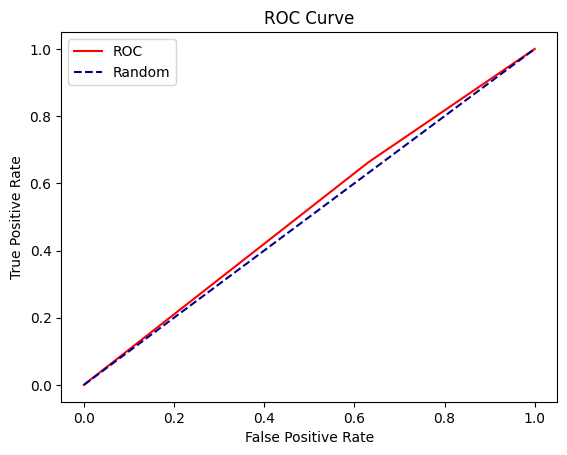

In [12]:
# plot ROC curve from confusion matrix
predict = predictions
True_label = labels
fpr, tpr, thresholds = roc_curve(True_label, predict)
auc = roc_auc_score(True_label, predict)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()